# Geometric Accuracy of Sentinel-1 NRB sample product

This notebooks uses Sentinel-1 NRB sample product generated over Australian corner reflector array site to measure the geometric accuracy of the product.

Comparison of 10m and 20m products.

### Load S1 sample data

HH band is available in ascending pass.

In [1]:
%matplotlib inline

import numpy as np
import xarray as xr
import os, glob
from matplotlib import pyplot as plt

In [2]:
#!pip install photutils # --user

In [4]:
#from photutils.centroids import centroid_2dg
from scipy import interpolate
from scipy import ndimage

In [5]:
# sinergise sample

def load_s1_sample_combined(s1_sample_path, band):
    fnames = glob.glob(f"{s1_sample_path}/*{band}.tif", recursive=True)
    data = []
    for fname in fnames:
        date = np.datetime64('-'.join(fname.split('/')[-1].split('/')[-1].split('_')[4:7]))
        data.append(xr.open_rasterio(fname, chunks={'x':1000, 'y':1000}).squeeze().to_dataset(name=band).expand_dims({'time':[date]}))
    dtype = data[0][band].dtype
    return xr.combine_by_coords(data).astype(dtype).sortby('time')

In [6]:
data = [load_s1_sample_combined('s1_sample_cr/10m', 'HH'),load_s1_sample_combined('s1_sample_cr/10m', 'MASK')]
combined_10 = xr.combine_by_coords(data)

data = [load_s1_sample_combined('s1_sample_cr/20m', 'HH'),load_s1_sample_combined('s1_sample_cr/20m', 'MASK')]
combined_20 = xr.combine_by_coords(data)

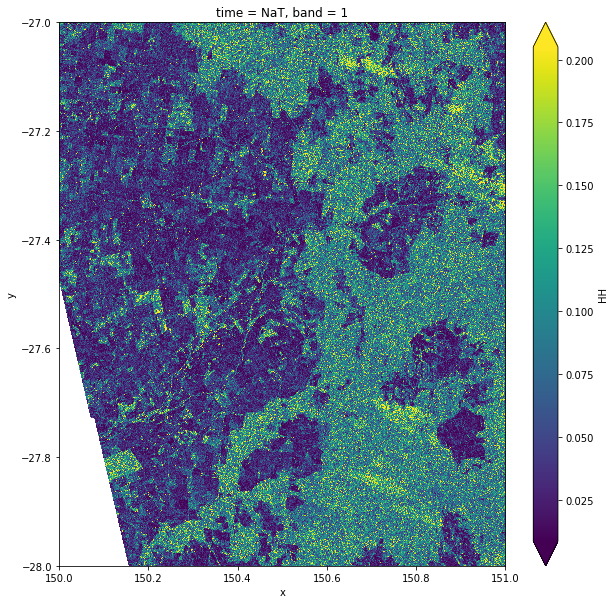

In [7]:
# quick visual check

combined_10.HH.isel(time=0).plot.imshow(robust=True, figsize=(10,10));

### Load corner reflector locations

In [8]:
import pandas as pd
import geopandas as gpd

In [9]:
df = pd.read_csv('s1_sample_cr/QLD_corner_reflector_positions_GDA2020.txt', sep="\s+", header=0)
cr_locations = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.Longitude, df.Latitude))
cr_locations.crs = 'EPSG:7844'

In [10]:
#cr_locations.to_crs(epsg='17355', inplace=True)
#cr_locations.to_crs(epsg='7844', inplace=True)
#cr_locations.crs

In [11]:
cr_locations.to_crs(epsg='4326', inplace=True)

In [12]:
cr_locations.head()

,Name,Latitude,Longitude,Height,X,Y,Z,veloX,veloY,veloZ,Azimuth,Elevation,geometry
0,SB01-CRApex,-26.834710,151.165604,409.4544,-4.989394e+06,2.746844e+06,-2.862070e+06,-0.0325,-0.0083,0.0487,257.10,53.32,POINT (151.16560 -26.83471)
1,SB02-CRApex,-26.951633,151.237613,432.7094,-4.987723e+06,2.737762e+06,-2.873636e+06,-0.0325,-0.0082,0.0486,256.21,53.33,POINT (151.23761 -26.95163)
2,SB03-CRApex,-27.100732,151.258809,391.8599,-4.982121e+06,2.732289e+06,-2.888335e+06,-0.0326,-0.0081,0.0485,258.46,54.34,POINT (151.25881 -27.10073)
3,SB04-CRApex,-27.308871,151.271959,385.2420,-4.973496e+06,2.726074e+06,-2.908845e+06,-0.0326,-0.0079,0.0484,258.51,54.67,POINT (151.27196 -27.30887)
4,SB05-CRApex,-27.456930,151.190830,403.0057,-4.963033e+06,2.729485e+06,-2.923422e+06,-0.0327,-0.0077,0.0484,258.20,55.36,POINT (151.19083 -27.45693)


In [13]:
cr_locations.crs

<Geographic 2D CRS: EPSG:4326>
Name: WGS 84
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: World
- bounds: (-180.0, -90.0, 180.0, 90.0)
Datum: World Geodetic System 1984
- Ellipsoid: WGS 84
- Prime Meridian: Greenwich

In [14]:
col_lat = [n for n in list(cr_locations.columns) if 'Latitude' in n]
col_lon = [n for n in list(cr_locations.columns) if 'Longitude' in n]

In [15]:
(abs(cr_locations[col_lat].values.transpose() - cr_locations.geometry.y.values)).max(), (abs(cr_locations[col_lon].values.transpose() - cr_locations.geometry.x.values)).max()

(0.0, 0.0)

In [17]:
cr_locations= cr_locations[cr_locations[col_lat].notnull().values & cr_locations[col_lon].notnull().values]

In [18]:
len(cr_locations)

40

### Extract backscatter around each CR and measture offsets

10 m resolution

# of CRs: 15
Center of mass method:
RMSE Latitude (pixel) 0.17264852582243018
RMSE Longitude (pixel) 0.461767238144858
RMSE Latitude (meter) 1.9219233894552927
RMSE Longitude (meter) 4.578397960185586
mean, std Latitude (meter) 1.7086970454155523 0.8798544890625287
mean, std Longitude (meter) -4.417692272821378 1.202382162411695


NameError: name 'centroid_2dg' is not defined

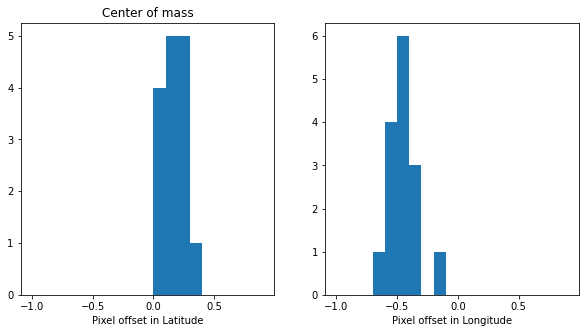

In [60]:
ps = 0.0001 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon_1 = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon_2 =111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon = (mpd_lon_1+mpd_lon_2)/2

hs = ps*6

data_crs = []
true_lats = []
true_lons = []

ntime = len(combined_10.time)
for i in range(ntime):
    s1 = combined_10.HH.isel(time=i).compute()

    for idx, row in cr_locations.iterrows():
        try:
            # is the CR in the scene?
            d = s1.sel(x = row.geometry.x, y = row.geometry.y, method='nearest', tolerance=0.002)
            x0, y0 = d.x.values, d.y.values
            #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            # is it visible?
            peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
            try:
                if peak.max()>3: 
                    #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                    data_crs.append(data)
                    true_lats.append(row.geometry.y)
                    true_lons.append(row.geometry.x)
                else:
                    print("not visible?", peak.max().values)
            except: 
                #print(i, data, peak)
                pass
        except KeyError:
            pass
    # 
    
print("# of CRs:", len(data_crs))

# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    y, x = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("Center of mass method:")
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)

f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('Center of mass')

# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("Gaussian centroid:")    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)


f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('Guassian Centroid')


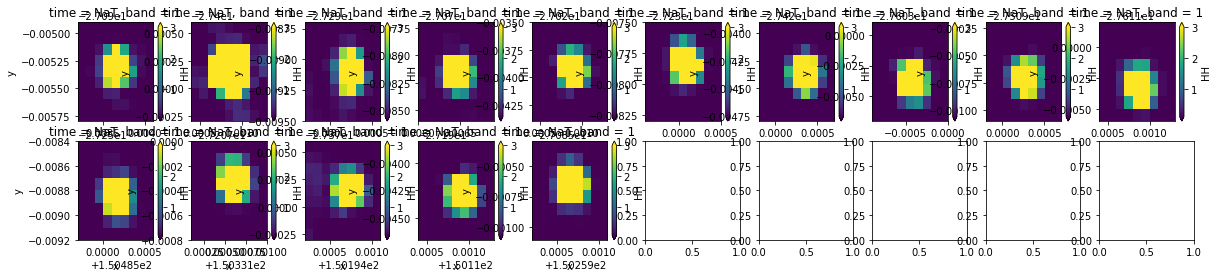

In [58]:
# visual check selected stamps
#f, ax = plt.subplots(4,10,figsize=(20,8))
f, ax = plt.subplots(2,10,figsize=(20,4))
ax = ax.flatten()
for i in range(len(data_crs[::ntime])):
    data_crs[i].plot.imshow(ax=ax[i], vmin=0.1, vmax=3);

## 20m

# of CRs: 15
Center of mass method:
RMSE Latitude (pixel) 0.12351182862535767
RMSE Longitude (pixel) 0.20649128632185765
RMSE Latitude (meter) 2.7498673525149635
RMSE Longitude (meter) 4.094700559053156
mean, std Latitude (meter) 1.0172334551297788 2.5548006877626257
mean, std Longitude (meter) -3.854582508837999 1.3815811054260942


NameError: name 'centroid_2dg' is not defined

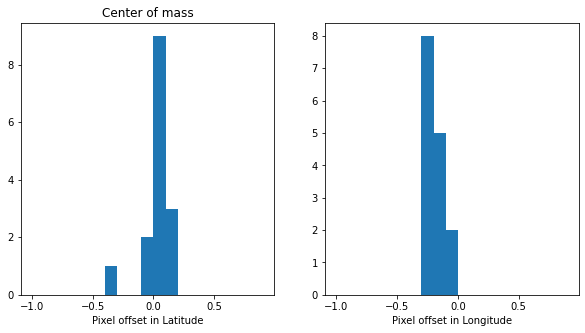

In [52]:
ps = 0.0002 # pixel scale in degree
mpd_lat = 111.32*1000 # meter per degree lat
mpd_lon_1 = 111.32*1000*np.cos(cr_locations.Latitude.values.max()*np.pi/180.) # maximum meter per degree lon
mpd_lon_2 =111.32*1000*np.cos(cr_locations.Latitude.values.min()*np.pi/180.) #for minimum meter per degree lon
mpd_lon = (mpd_lon_1+mpd_lon_2)/2

hs = ps*3

data_crs = []
true_lats = []
true_lons = []

ntime = len(combined_20.time)
for i in range(ntime):
    s1 = combined_20.HH.isel(time=i).compute()

    for idx, row in cr_locations.iterrows():
        try:
            # is the CR in the scene?
            d = s1.sel(x = row.geometry.x, y = row.geometry.y, method='nearest', tolerance=0.002)
            x0, y0 = d.x.values, d.y.values
            #data_crs[idx] = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            data = s1.sel(x = slice(x0-hs, x0+hs), y = slice(y0+hs, y0-hs))
            # is it visible?
            peak = data.where(data==data.max()).dropna(dim='x', how='all').dropna(dim='y', how='any')
            try:
                if peak.max()>3: 
                    #print(row[col_lon].values, peak.x.values[0], row[col_lat].values, peak.y.values[0])
                    data_crs.append(data)
                    true_lats.append(row.geometry.y)
                    true_lons.append(row.geometry.x)
                else:
                    print("not visible?", peak.max().values)
            except: 
                #print(i, data, peak)
                pass
        except KeyError:
            pass
    # 

print("# of CRs:", len(data_crs))

# center of mass all pixel

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # center of mass
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    y, x = ndimage.measurements.center_of_mass(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("Center of mass method:")
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)

f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('Center of mass')

# gaussian centroid 

c_lats = []
c_lons = []
for i in range(len(data_crs)):
    
    # gaussian centroid
    fx = interpolate.interp1d(np.arange(len(data_crs[i].x)), data_crs[i].x.values)
    fy = interpolate.interp1d(np.arange(len(data_crs[i].y)), data_crs[i].y.values)
    x, y = centroid_2dg(data_crs[i].values)
    c_lon, c_lat = fx(x), fy(y)
    
    c_lats.append(c_lat)
    c_lons.append(c_lon)

print("Gaussian centroid:")    
print("RMSE Latitude (pixel)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))/ps)
print("RMSE Longitude (pixel)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))/ps)    
print("RMSE Latitude (meter)", np.sqrt(np.mean((np.array(true_lats) - c_lats)**2))*mpd_lat)
print("RMSE Longitude (meter)", np.sqrt(np.mean((np.array(true_lons) - c_lons)**2))*mpd_lon)

print("mean, std Latitude (meter)", np.mean(np.array(true_lats) - c_lats)*mpd_lat, np.std(np.array(true_lats) - c_lats)*mpd_lat)
print("mean, std Longitude (meter)", np.mean(np.array(true_lons) - c_lons)*mpd_lon, np.std(np.array(true_lons) - c_lons)*mpd_lon)

f, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].hist((np.array(true_lats) - c_lats)/ps, bins=np.arange(-1,1,0.1));
ax[0].set_xlabel('Pixel offset in Latitude');
ax[1].hist((np.array(true_lons)  - c_lons)/ps, bins=np.arange(-1,1,0.1));
ax[1].set_xlabel('Pixel offset in Longitude');
ax[0].set_title('Guassian Centroid')


In [47]:
a = np.zeros((5,5))
a[2,2]=1
x= y = np.arange(5)

In [ ]:
plt.imshow(a)

In [ ]:
new_x, new_y = x+0.8, y+0.9

f = interpolate.interp2d(x, y, a)
t = f(new_x, new_y)
print(t)

In [ ]:
plt.imshow(t)

In [ ]:
y, x = ndimage.measurements.center_of_mass(t)
new_x[0]+x, new_y[0]+y

In [ ]:
x, y = centroid_2dg(t)
new_x[0]+x, new_y[0]+y